In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


# Setup (determine subnetwork based on components) #

## get graphs ##

In [2]:
pcmci_res_path='./output/gridSearch/alpha=3e-20_nVAR=100' #select path with PCMCI results of the ensembles
pca_res_path='./c-transfer'
alpha_levelTest=0.0001       #select (optimal) mci_alpha
use_CMIP6_data=True

In [3]:
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']

In [4]:
nrEnsembles=0
graphMats=[]
plotDict={}



make_dic=True 
n_kept_comp = 100 
selected_comps_indices=None
var_names=["X_"+str(i) for i in range(0,n_kept_comp)]




resTestPath=pcmci_res_path+"/results_*.bin"
resTest1=None
file_nameTest=""
for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):       
    res = pickle.load(open(res_file,"rb"))
    resTest = res
    resTest1=resTest
    #print(resTest1)
    file_nameTest = resTest1['file_name']
    
    
    
    #selected_comps_indices=resTest1['variables']
    selected_comps_indices=range(0, n_kept_comp)
    
    
    
    name=file_nameTest
    file_nameTest = pca_res_path+"/"+ file_nameTest
    info_model= file_nameTest.split("_")
    dataset_name = info_model[2]               #on error change to 2 or 3
    ensemble=""
    if dataset_name != "ncar":
        dataset_name= info_model[2]
        if use_CMIP6_data:
            ensemble= info_model[5]  #on error change to 5 or 6
        else : ensemble= info_model[7]
    if dataset_name == "GISS-E2-R":
        ensemble= info_model[5]
    if dataset_name == "ERA5":
        ensemble= ""
    season= info_model[-1][7:-4]


    datadictTest = cPickle.load(open(file_nameTest, 'rb'))
    dTest = datadictTest['results']
    time_maskTest = dTest['time_mask']
    dateseriesTest = dTest['time'][:]
    fulldataTest = dTest['ts_unmasked']
    N = fulldataTest.shape[1]
    fulldata_mask = np.repeat(time_maskTest.reshape(len(dTest['time']), 1), N, axis=1)

    fulldataTest = fulldataTest[:, selected_comps_indices]
    fulldata_mask = fulldata_mask[:, selected_comps_indices]
    dataframeTest = pp.DataFrame(fulldataTest, mask=fulldata_mask)
    T, N = dataframeTest.values[0].shape
    CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
    cond_ind_test = ParCorr(**CI_params)
    pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframeTest, verbosity=0)


    graphTest = pcmci.get_graph_from_pmatrix(p_matrix=resTest1['results']['p_matrix'],
                                     alpha_level=alpha_levelTest,
                                     tau_min=1,
                                     tau_max=10,
                                     link_assumptions=None,)

    graphMats.append((dataset_name, ensemble, graphTest))
    nrEnsembles=nrEnsembles+1
    valMatrixTest = resTest1['results']['val_matrix']
    
    plotDict[file_nameTest]=(graphTest, valMatrixTest, datadictTest, name)

## get overlap graphs ##

In [5]:
overlaps_=np.zeros(graphMats[0][2].shape) #calculate overlaps matrix
count=0
for dataset_name, ensemble, graphMat in graphMats:
    numeric_array = np.where(np.logical_or(graphMat == '', graphMat == 'o-o'), 0, 1).astype(int) #do not count non causal links
    overlaps_=overlaps_+numeric_array
    count=count+1

In [6]:
tresholdMostLinks=1*nrEnsembles
tresholdLeastLinks=10
leastOverlaps = np.where((overlaps_ <= tresholdLeastLinks) & (overlaps_ > 2), 'o-o', '')
mostOverlaps = np.where(overlaps_ >= tresholdMostLinks, 'o-o', '')

## get coordinates of the components ##

In [7]:
coordsDict={}        #get coordinates of components
coords_={}


for key in plotDict:
    lonsTest=datadictTest['results']['lons']
    latsTest=datadictTest['results']['lats']
    #print(weightsTest.shape)
    #np.argmax(weightsTest)
    #print(lonsTest.shape)
    #print(latsTest.shape)
    #print(lonsTest)
    #print(latsTest)
    weightsTest=datadictTest['results']['weights']
    #print(weightsTest)
    weightsTest=np.array(weightsTest.reshape(len(latsTest),len(lonsTest), 100))
    #print(weightsTest)
    #coordsMax=np.argmax(weightsTest, keepdims=True)


    coords = []
    for k in selected_comps_indices:
        i,j = np.unravel_index(np.argmax(np.abs(weightsTest[:,:,k])), weightsTest[:,:,k].shape)
        coords.append((latsTest[i], lonsTest[j]))
    coordsDict[key]=(lonsTest, latsTest, weightsTest, coords)
    coords_[0]=(lonsTest, latsTest, weightsTest, coords)
    #print(coordsMax)
    #print(weightsTest.shape)
    #print(weightsTest[:,:,0]) #reihe = lat column = lon


In [8]:
coordsTest=[]
for i, element in enumerate(coords_[0][3]):
    coordsTest.append((element, i))

In [10]:
filterComps=[] #optional: get all components
for element in coordsTest:
    if (element[0][0]>=18.0): #above latitude -18
        filterComps.append(element[1])


# Plotting 1) #

## plot leastOverlaps ##

<class 'numpy.ndarray'>


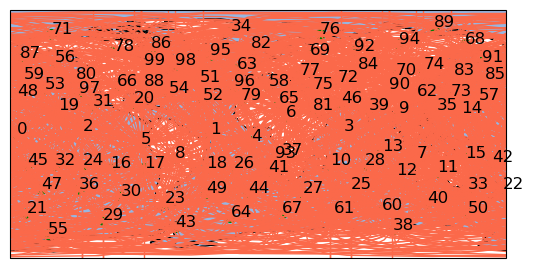

In [11]:
#print
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.feature as cfeature
import matplotlib as mpl


cmapReds = mpl.cm.Reds
cmapBlues = mpl.cm.Blues
normReds = mpl.colors.Normalize(vmin=0, vmax=1)
normBlues = mpl.colors.Normalize(vmin=0, vmax=1)



ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

#print("(-->, i, j, tau) = Kante von i nach j in Zeitschritt tau")
graphTest=leastOverlaps #mostOverlaps
valMatrixTest=np.full_like(leastOverlaps, 0.5, dtype=float) #mostOverlaps
print(type(valMatrixTest))
coords=coords_[0][3]

tempDict = {}
for i, element in enumerate(coords):
    ax.plot(element[1],element[0], 'go', markersize=7, transform=ccrs.Geodetic())
    ax.text(element[1], element[0], i, transform=ccrs.Geodetic(), fontsize=12, color='black',)

for i in range(0, n_kept_comp):
    for j in range(0, n_kept_comp):
        for k in range(0,11): #range von 0 bis tau_max+1
            if (graphTest[i][j][k] == 'o-o' and i<=j and k == 0) or (graphTest[i][j][k] == 'o-o' and k>0):
                #print("o-o", i, j, k)
                if abs(valMatrixTest[i][j][k])>abs(valMatrixTest[j][i][k]):
                    color = None
                    if valMatrixTest[i][j][k]>0:
                        color = cmapReds(normReds(valMatrixTest[i][j][k]))
                    else:
                        color = cmapBlues(normBlues(abs(valMatrixTest[i][j][k])))
                else:
                    if valMatrixTest[j][i][k]>0:
                        color = cmapReds(normReds(valMatrixTest[j][i][k]))
                    else:
                        color = cmapBlues(normBlues(abs(valMatrixTest[j][i][k])))

                plt.plot([coords[i][1], coords[j][1]], [coords[i][0], coords[j][0]],
                     color=color, linewidth=1, marker=None, transform=ccrs.Geodetic())

for key in tempDict:
    #print(key)
    if tempDict[key]>0:
        color = cmapReds(normReds(tempDict[key]))
    else:
        color = cmapBlues(normBlues(abs(tempDict[key])))
    ax.annotate('', xy=(coords[key[1]][1], coords[key[1]][0]), xytext=(coords[key[0]][1], coords[key[0]][0]),
                        xycoords='data',
                        size=10,
                        arrowprops=dict(facecolor=color, ec = 'none',
                            arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.3"))

plt.show()

## plot mostOverlaps ##

<class 'numpy.ndarray'>


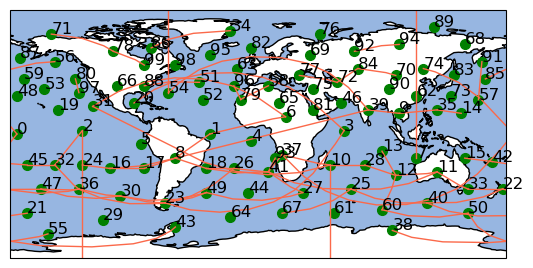

In [12]:
#cartopy Zeugs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.feature as cfeature
import matplotlib as mpl


cmapReds = mpl.cm.Reds
cmapBlues = mpl.cm.Blues
normReds = mpl.colors.Normalize(vmin=0, vmax=1)
normBlues = mpl.colors.Normalize(vmin=0, vmax=1)



ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

#print("(-->, i, j, tau) = Kante von i nach j in Zeitschritt tau")
graphTest=mostOverlaps #mostOverlaps
valMatrixTest=np.full_like(mostOverlaps, 0.5, dtype=float) 
print(type(valMatrixTest))
coords=coords_[0][3]

tempDict = {}
for i, element in enumerate(coords):
    ax.plot(element[1],element[0], 'go', markersize=7, transform=ccrs.Geodetic())
    ax.text(element[1], element[0], i, transform=ccrs.Geodetic(), fontsize=12, color='black',)

for i in range(0, n_kept_comp):
    for j in range(0, n_kept_comp):
        for k in range(0,11): #range von 0 bis tau_max+1
            if (graphTest[i][j][k] == 'o-o' and i<=j and k == 0) or (graphTest[i][j][k] == 'o-o' and k>0):
                #print("o-o", i, j, k)
                if abs(valMatrixTest[i][j][k])>abs(valMatrixTest[j][i][k]):
                    color = None
                    if valMatrixTest[i][j][k]>0:
                        color = cmapReds(normReds(valMatrixTest[i][j][k]))
                    else:
                        color = cmapBlues(normBlues(abs(valMatrixTest[i][j][k])))
                else:
                    if valMatrixTest[j][i][k]>0:
                        color = cmapReds(normReds(valMatrixTest[j][i][k]))
                    else:
                        color = cmapBlues(normBlues(abs(valMatrixTest[j][i][k])))

                plt.plot([coords[i][1], coords[j][1]], [coords[i][0], coords[j][0]],
                     color=color, linewidth=1, marker=None, transform=ccrs.Geodetic())

    
for key in tempDict:
    #print(key)
    if tempDict[key]>0:
        color = cmapReds(normReds(tempDict[key]))
    else:
        color = cmapBlues(normBlues(abs(tempDict[key])))
    ax.annotate('', xy=(coords[key[1]][1], coords[key[1]][0]), xytext=(coords[key[0]][1], coords[key[0]][0]),
                        xycoords='data',
                        size=10,
                        arrowprops=dict(facecolor=color, ec = 'none',
                            arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.3"))
#plt.savefig('karte.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.savefig('./BilderBA/'+'mostOverlapsMap2bestSetting'+'.pdf',dpi=600)

plt.show()

# determine discrepancy generating components #

In [13]:
def calculate_leastOverlaps_div_mostOverlaps(lstOverlaps, mstOverlaps):
    index=0
    leastDivMost=[]
    for i, element in enumerate(lstOverlaps):
        non_empty_count1 = np.count_nonzero(lstOverlaps[i] != '')
        non_empty_count2 = np.count_nonzero(mstOverlaps[i] != '')
        #print(non_empty_count1, non_empty_count2)
        if non_empty_count2==0:
            leastDivMost.append((10000, index))
        else:
            leastDivMost.append((non_empty_count1/non_empty_count2, index))
        index=index+1
    return leastDivMost

In [14]:
l=calculate_leastOverlaps_div_mostOverlaps(leastOverlaps, mostOverlaps)

In [15]:
liste2=[]
for element in l:
    if element[0]>8: #minimum quotient k_discrepancy
        liste2.append(element[1])